In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import os
from os.path import join
from shapely.geometry import Polygon
from pygeotile.tile import Tile
%matplotlib inline

def qt2geom(qt):
    bbox = Tile.from_quad_tree(qt).bounds
    # min_lng, min_lat, max_lng, max_lat
    poly = Polygon.from_bounds(bbox[0][1], bbox[0][0], bbox[1][1], bbox[1][0]) 
    return poly

def read_cellphone_data(filename):
    data = pd.read_csv(filename,
                       header = None,
                       # a typical dataset has 9 columns with these names
                       names = ['qtid_origin',
                                'qtid_destination',
                                'OD_counts', 
                                'num_dates',
                                'avg_travel_distance (mile)',
                                'avg_travel_time (second)',
                                'time_period',
                                'dominant_mode_1',
                                'dominant_mode_2'],
                       dtype={'qtid_origin': object, 'qtid_destination': object},                       
                      nrows=20000,
                      )
    return data


def get_geo(filename):
    data = read_cellphone_data(filename)
    # get all qtid in the dataset (origin and destination)
    qt_list = pd.concat([data.qtid_origin, data.qtid_destination]).unique()
    qt_poly = list(map(qt2geom,qt_list))
    qt_dict = gpd.GeoDataFrame(pd.DataFrame(data={'qtid':qt_list,'geometry':qt_poly}))
    return qt_dict

In [2]:
data_dir = "cellphone data 2/fall2017-summer2018/"

In [3]:
nyc_shp = get_geo(data_dir + 'nyc_all.csv')

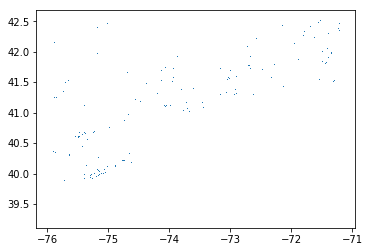

In [4]:
nyc_shp.plot()

In [5]:
nyc_shp.head()

,qtid,geometry
0,030232213331113120,"POLYGON ((-75.9429931640625 42.15220521114355,..."
1,030232213331331113,POLYGON ((-75.93887329101563 42.11248648904184...
2,030232213331333330,POLYGON ((-75.94024658203125 42.09924138032294...
3,030232233113113333,POLYGON ((-75.93887329101563 41.42625319507269...
4,030232233133331321,POLYGON ((-75.94161987304688 41.25406487942275...


In [6]:
nyc_df = read_cellphone_data(data_dir + 'nyc_all.csv')

In [7]:
nyc_df.head()

,qtid_origin,qtid_destination,OD_counts,num_dates,avg_travel_distance (mile),avg_travel_time (second),time_period,dominant_mode_1,dominant_mode_2
0,030232213331113120,030232213331113120,4,2,0.009944,621.73430,10:00 - 10:30,stay,stay
1,030232213331331113,030232213331331112,2,1,0.009991,422.91666,8:00 - 8:30,stay,stay
2,030232213331331113,030232213331331113,8,4,0.002881,678.78125,10:00 - 10:30,stay,stay
3,030232213331333330,030232213331333330,2,2,0.006721,581.08330,6:00 - 6:30,pedestrian,pedestrian
4,030232213331333330,030232213331333330,1,1,0.001947,410.19696,8:30 - 9:00,stay,stay


In [8]:
nyc_df.groupby(['qtid_origin','qtid_destination','time_period']).count().shape

(19987, 6)

In [9]:
nyc_df.shape

(20000, 9)

In [10]:
from bokeh.plotting import figure, show, ColumnDataSource, save
from bokeh.embed import components
from bokeh.io import output_notebook
from bokeh.models import FactorRange, CategoricalColorMapper, HoverTool, ColumnDataSource, Panel
from bokeh.models.widgets import CheckboxGroup, Slider, RangeSlider, Tabs

from bokeh.layouts import column, row, WidgetBox
from bokeh.palettes import Category20_16

from bokeh.application.handlers import FunctionHandler
from bokeh.application import Application

In [11]:
output_notebook()

Loading BokehJS ...

In [12]:
def getPolyCoords(row, geom, coord_type):
    """Returns the coordinates ('x' or 'y') of edges of a Polygon exterior"""
    
    # Parse the exterior of the coordinate
    exterior = row[geom].exterior

    if coord_type == 'x':
        # Get the x coordinates of the exterior
        return list( exterior.coords.xy[0] )
    elif coord_type == 'y':
        # Get the y coordinates of the exterior
        return list( exterior.coords.xy[1] )

In [13]:
def getVectorCoords(row, geom, coord_type):
    """Returns the coordinates ('x' or 'y') of edges of a Polygon exterior"""
    join_row = nyc_shp[nyc_shp['qtid']==row[geom]]
    join_row = list(join_row['geometry'])[0]
    
    # Parse the exterior of the coordinate
    centroid = join_row.centroid

    if coord_type == 'x':
        # Get the x coordinates of the exterior
        return centroid.coords.xy[0][0]
    elif coord_type == 'y':
        # Get the y coordinates of the exterior
        return centroid.coords.xy[1][0]

In [14]:
# Get the Polygon Centroid x and y coordinates
nyc_df['x0'] = nyc_df.apply(getVectorCoords, geom='qtid_origin', coord_type='x', axis=1)
nyc_df['y0'] = nyc_df.apply(getVectorCoords, geom='qtid_origin', coord_type='y', axis=1)
nyc_df['x1'] = nyc_df.apply(getVectorCoords, geom='qtid_destination', coord_type='x', axis=1)
nyc_df['y1'] = nyc_df.apply(getVectorCoords, geom='qtid_destination', coord_type='y', axis=1)

In [15]:
# Get the Polygon x and y coordinates
nyc_shp['x'] = nyc_shp.apply(getPolyCoords, geom='geometry', coord_type='x', axis=1)
nyc_shp['y'] = nyc_shp.apply(getPolyCoords, geom='geometry', coord_type='y', axis=1)

In [16]:
# Make a copy, drop the geometry column and create ColumnDataSource
nyc_shp_source = nyc_shp.drop('geometry', axis=1).copy()
nyc_shp_source = ColumnDataSource(nyc_shp_source)

In [17]:
# Make a copy, drop the geometry column and create ColumnDataSource
nyc_df_source = nyc_df.copy()
nyc_df_source = ColumnDataSource(nyc_df_source)

In [18]:
boro_shp = gpd.read_file("Borough Boundaries/geo_export_dab0de5c-dadd-4bea-9105-37b2d151df7e.shp")

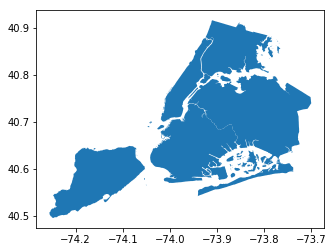

In [19]:
boro_shp.plot()

In [20]:
def getAllBoro(geoms,boros):
    x = []
    y = []
    boro_list = []
    for geom, boro in zip(geoms,boros):
        for sub_geom in geom:
            x.append(list(sub_geom.exterior.coords.xy[0]))
            y.append(list(sub_geom.exterior.coords.xy[1]))
            boro_list.append(boro)
    return x,y,boro_list

In [21]:
x,y,boro_list = getAllBoro(boro_shp['geometry'],boro_shp['boro_name'])

In [22]:
boro_source = pd.DataFrame(data = {'x':x,'y':y,'boro_name':boro_list})
boro_source = boro_source.copy()
boro_source = ColumnDataSource(boro_source)

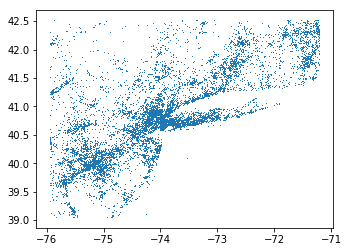

In [23]:
qt = gpd.read_file('cellphone data 2/quadtree_dictionary/nyc_quadtree/nyc_quadtree.shp')
qt.plot()

In [24]:
qt.head()

,qtid,geometry
0,030232213331113120,"POLYGON ((-75.9429931640625 42.15220521114355,..."
1,030232213331331113,POLYGON ((-75.93887329101563 42.11248648904184...
2,030232213331333330,POLYGON ((-75.94024658203125 42.09924138032294...
3,030232233113113333,POLYGON ((-75.93887329101563 41.42625319507269...
4,030232233133331321,POLYGON ((-75.94161987304688 41.25406487942275...


In [25]:
available_modes = nyc_df['dominant_mode_2'].unique().tolist()

In [26]:
def modify_doc(doc):
    
    def make_dataset(modes_list,range_start,range_end):
        times_list = []
        for i in [x/10.0 for x in range(range_start*10,range_end*10+5,5)]:
            if(i%1==0):
                times_list.append(str(int(i)) + ':00'+ ' - ' + str(int(i)) + ':30')
            else:
                times_list.append(str(int(i)) + ':30'+ ' - ' + str(int(i+1)) + ':00')

        subset = nyc_df[(nyc_df['time_period'].isin(times_list))&(nyc_df['dominant_mode_2'].isin(modes_list))]

        return ColumnDataSource(subset)
    
    def make_plot(src):
        # Blank plot with correct labels
        p = figure(plot_width = 700, plot_height = 600, 
                  title = 'Greater NYC Commute by Time Period and Modes')

        # Plot grid
        p.patches('x', 'y', source=boro_source, fill_alpha=0.25, line_color="blue", line_width=0.5)

        p.segment(x0='x0', y0='y0', x1='x1', y1='y1', source=src, color="red", line_width=1.0)

        #Add Hover
        #hover = HoverTool(tooltips = [('(x,y)', '($x,$y)'),('dominant_mode_2', '@dominant_mode_2')],mode = 'vline')
        #p.add_tools(hover)

        return p
    
    # Update function takes three default parameters
    def update(attr, old, new):
        # Get the list of carriers for the graph
        modes_to_plot = [modes_selection.labels[i] for i in 
                            modes_selection.active]
        
        # Value for the range slider is a tuple (start, end)

        range_start = range_select.value[0]

        range_end = range_select.value[1]

        # Make a new dataset based on the selected carriers and the 
        # make_dataset function defined earlier
        new_src = make_dataset(modes_to_plot,range_start,range_end)

        # Update the source used the quad glpyhs
        src.data.update(new_src.data)

        
    modes_selection = CheckboxGroup(labels=available_modes, active = [2])
    modes_selection.on_change('active', update)
    
    
    # RangeSlider to change the maximum and minimum values on time_period

    range_select = RangeSlider(start = 6, end = 10, value = (6, 8),

                               step = 1, title = 'Time Range')

    # Update the plot when the value is changed

    range_select.on_change('value', update)

    
    controls = WidgetBox(modes_selection,range_select)
    
    initial_modes = [modes_selection.labels[i] for i in modes_selection.active]
    
    src = make_dataset(initial_modes,6,8)
    
    p = make_plot(src)
    
    layout = row(controls, p)
    doc.add_root(layout)
    
# Set up an application
handler = FunctionHandler(modify_doc)
app = Application(handler)

In [27]:
show(app)

# Static Screenshot

<img src='Bokeh_Mode_Time.png'>